In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import warnings ; warnings.filterwarnings('ignore')
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['OMP_NUM_THREADS'] = '1'

import pybullet_envs
import argparse
import gfootball.env as football_env
import gym
import ray
from ray.rllib.agents import ppo
from ray import tune
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray.tune.registry import register_env

import tempfile
import gym
from gfootball import env as fe
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from gym import wrappers

import ray
from ray import tune
from IPython.display import HTML

from utils import gif_tools as gt
from utils import football_tools as ft

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
!pip list | grep -i gfootball
!pip list | grep -i ray
!pip list | grep -i tensorflow
!pip list | grep -i tensorboard
!pip list | grep -i torch

gfootball                2.5
ray                      1.0.0
tensorflow               2.3.1
tensorflow-estimator     2.3.0
tensorboard              2.3.0
tensorboard-plugin-wit   1.7.0
tensorboardX             2.1
torch                    1.4.0
torchvision              0.5.0


In [3]:
!nvidia-smi

Fri Nov  6 19:06:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:0B:00.0 Off |                  N/A |
| 23%   33C    P8    10W / 250W |      2MiB / 12196MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:41:00.0 Off |                  N/A |
| 23%   

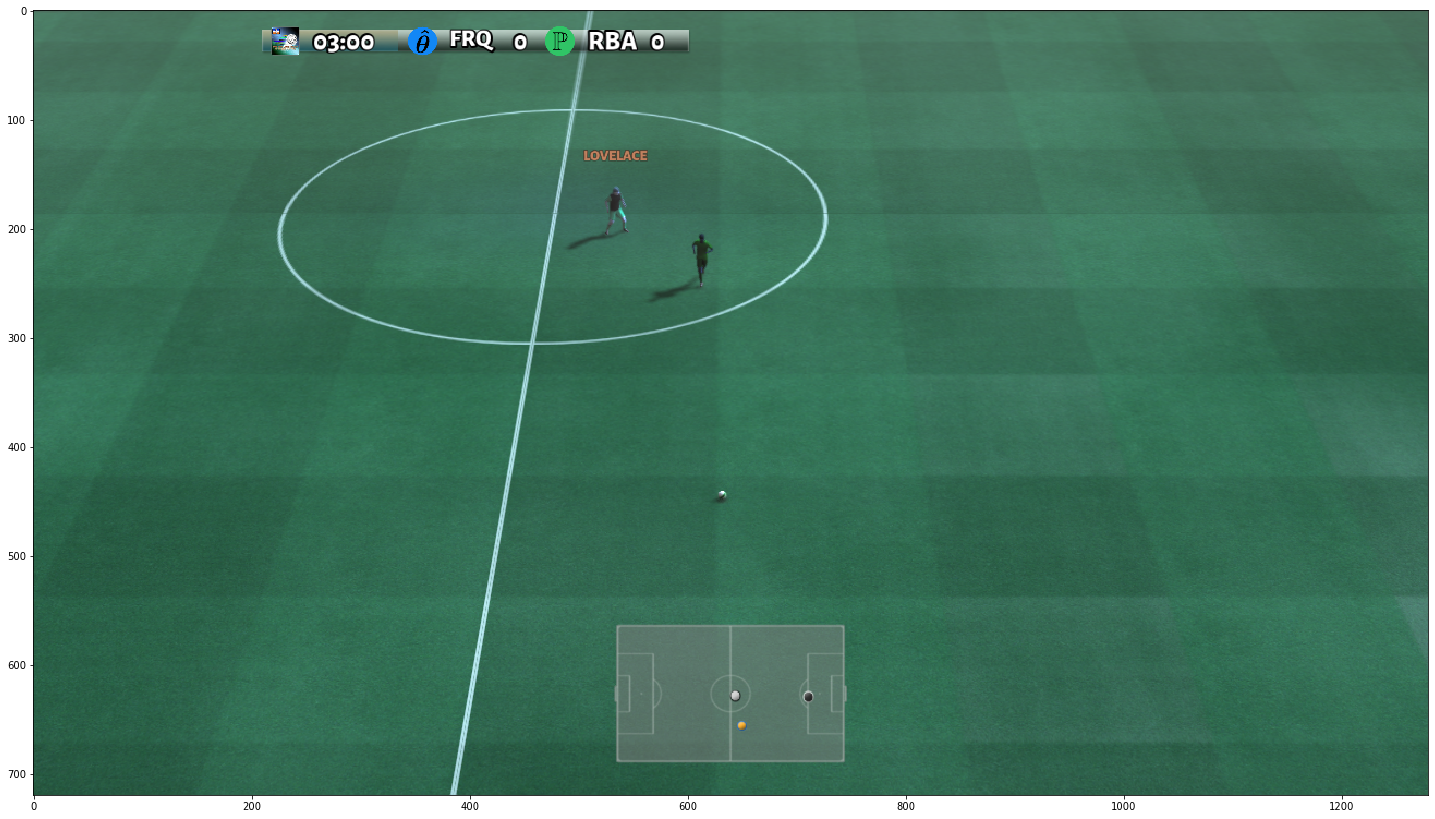

In [4]:
try:
    del env
except:
    pass
env = fe.create_environment(env_name="1_vs_1", render=True)
# env = fe.create_environment(env_name="2_vs_2", render=True)
# env = fe.create_environment(env_name="2_vs_2_auto_GK", render=True)
# env = fe.create_environment(env_name="3_vs_3", render=True)
# env = fe.create_environment(env_name="3_vs_3_auto_GK", render=True)
# env = fe.create_environment(env_name="4_vs_4", render=True)
# env = fe.create_environment(env_name="4_vs_4_auto_GK", render=True)
# env = fe.create_environment(env_name="5_vs_5", render=True)
# env = fe.create_environment(env_name="5_vs_5_auto_GK", render=True)
[env.step(env.action_space.sample()) for _ in range(100)]
img = env.render("rgb_array")
fig, ax = plt.subplots(figsize=(25, 20))
ax.imshow(img, interpolation='nearest')

In [5]:
print(env.reset().shape)
env.disable_render()
del env

(72, 96, 4)


In [6]:
env = ft.create_football_env(n_vs_n=1, auto_GK=True, add_checkpoint=True, dump_frequency=1)

In [7]:
env.observation_space

Box(-inf, inf, (115,), float32)

In [8]:
env.observation_space.sample()

array([-0.709362  , -0.7126577 , -1.6658269 , -0.03745066, -0.44132376,
       -0.25901324,  0.15571596,  1.0366014 ,  0.67400366,  0.30059582,
       -1.3498917 , -1.5317146 ,  0.8598112 , -1.4636923 , -0.9385768 ,
       -0.17862171,  0.26603848,  0.34781924, -0.7318196 , -1.5972497 ,
        0.5222887 , -0.5322143 ,  0.02662668,  0.52278936,  1.289982  ,
        1.5449178 ,  0.0991618 ,  0.92624766, -0.27266553, -1.3270949 ,
       -1.114081  , -0.26997128, -1.0706353 , -0.23065042, -0.39232066,
       -1.3801123 , -1.6636724 , -0.23826277, -0.11570827,  0.4508629 ,
       -1.322109  , -1.7823448 ,  0.21205232,  1.1622797 ,  0.32757032,
        0.7276953 , -0.08418109,  0.83020616,  1.0881686 ,  0.13774525,
        1.4993917 , -1.4163306 , -2.045362  , -1.0840855 ,  0.25854182,
       -0.25361234,  1.0926049 , -0.811324  , -0.65520155,  0.40399826,
        0.39190122,  1.2531683 , -0.39789456, -1.5765293 ,  1.1506772 ,
       -0.20051916, -0.6118159 ,  0.22378552, -1.2319568 ,  0.22

In [9]:
env.action_space

Discrete(19)

In [10]:
env.action_space.sample()

6

In [11]:
try:
    del tmp_env
except:
    pass
tmp_env = gym.make('HopperBulletEnv-v0')
print('Observation space:')
print('    --> Space: ' + str(tmp_env.observation_space))
print('    --> Sample: ' + str(tmp_env.observation_space.sample()))
print('\nAction space:')
print('    --> Space: ' + str(tmp_env.action_space))
print('    --> Sample: ' + str(tmp_env.action_space.sample()))
del tmp_env

Observation space:
    --> Space: Box(-inf, inf, (15,), float32)
    --> Sample: [ 0.65617365  0.68702614 -0.64896005 -1.4389375   0.15154384 -0.55489135
  0.8633821   0.9058795  -1.0268422   0.10718995 -0.21727279 -0.12626894
 -0.6286732  -0.70353705  0.34819373]

Action space:
    --> Space: Box(-1.0, 1.0, (3,), float32)
    --> Sample: [-0.682272   -0.01826143 -0.24946624]


In [12]:
env.reset()

array([-1.0110294 , -0.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        ,  0.        , -0.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        ,  1.0110294 ,
        0.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -0.        ,  0.        , -1.        , -1.  

In [13]:
_ = [env.step(env.action_space.sample()) for _ in range(100)]

In [14]:
o, r, d, i = env.step(env.action_space.sample())

In [15]:
o

array([-1.01417392e-01, -1.71192102e-02, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00,  1.95582118e-03,  3.07873683e-03,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        8.26035619e-01,  3.07496761e-09, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -

In [16]:
r

0.0

In [17]:
d

False

In [18]:
i

{'score_reward': 0}

In [19]:
!rm -rf /tmp/football/*

In [20]:
n_episodes=5
n_videos=3

for e in tqdm(range(n_episodes)):
    ret, obs, done = 0, env.reset(), False
    while not done:
        obs, rew, done, info = env.step(env.action_space.sample())
        ret += rew
    print(f"Episode={e}, Return={ret}")

Episode=0, Return=-1.0
Episode=1, Return=-2.0
Episode=2, Return=0.0
Episode=3, Return=-1.0
Episode=4, Return=-2.0



In [24]:
!ls /tmp/football/ -lhS

total 38M
-rw------- 1 jovyan users 4.9M Nov  6 17:29 episode_done_20201106-172916956365.avi
-rw------- 1 jovyan users 4.8M Nov  6 17:29 episode_done_20201106-172930068865.avi
-rw------- 1 jovyan users 4.8M Nov  6 17:29 episode_done_20201106-172902847955.avi
-rw------- 1 jovyan users 4.7M Nov  6 17:29 episode_done_20201106-172848728751.avi
-rw------- 1 jovyan users 4.7M Nov  6 17:29 episode_done_20201106-172944515133.avi
-rw-r--r-- 1 jovyan users 2.0M Nov  6 17:29 episode_done_20201106-172930068865.dump
-rw-r--r-- 1 jovyan users 2.0M Nov  6 17:29 episode_done_20201106-172944515133.dump
-rw-r--r-- 1 jovyan users 2.0M Nov  6 17:29 episode_done_20201106-172902847955.dump
-rw-r--r-- 1 jovyan users 2.0M Nov  6 17:29 episode_done_20201106-172916956365.dump
-rw-r--r-- 1 jovyan users 2.0M Nov  6 17:29 episode_done_20201106-172848728751.dump
-rw------- 1 jovyan users 529K Nov  6 17:29 lost_score_20201106-172949187392.avi
-rw------- 1 jovyan users 515K Nov  6 17:29 lost_score_20201106-1729107240


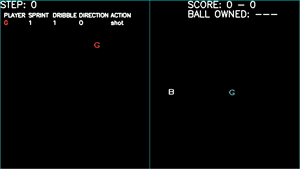
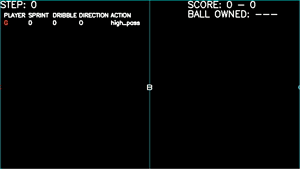
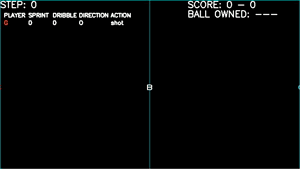

In [25]:
data = gt.get_gif_html(videos_path="/tmp/football/*.avi", 
                    title="GFootball Test",
                    max_n_videos=n_videos)
HTML(data=data)

In [26]:
!nvidia-smi

Fri Nov  6 17:34:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:0B:00.0 Off |                  N/A |
| 23%   32C    P8    10W / 250W |      2MiB / 12196MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:41:00.0 Off |                  N/A |
| 23%   

In [44]:
!grep -c 'processor' /proc/cpuinfo

32


In [2]:
# !rm -rf /tmp/ray/*
# !rm -rf /tmp/logs/*

# ray.init(log_to_driver=False,
#          local_mode=False,
#          _temp_dir='/tmp/ray')
tune.run(
    "PPO",
    stop={"episode_reward_mean": 150},
    local_dir="/tmp/logs",
    name="cart_pole",
    config={
        "env": "CartPole-v0",
        "num_gpus": 1,
        "num_workers": 8,
        "lr": 0.0001,
        "log_level": "ERROR",
    },
    verbose=1,
)

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v0_d6984_00000,TERMINATED,,6,31.2544,28800,170.26,200,16,170.26


In [3]:
print('Training logs:')
!ls /tmp/logs
print('\nRay logs:')
!ls /tmp/ray/session_latest/logs/

!rm -rf /tmp/logs/*

Training logs:
cart_pole

Ray logs:
dashboard.err
dashboard.out
gcs_server.err
gcs_server.out
log_monitor.err
log_monitor.out
monitor.err
monitor.out
old
plasma_store.err
plasma_store.out
python-core-driver-01000000ffffffffffffffffffffffffffffffff.20201106-204416.9586.log
python-core-worker-18eb97727682c7d1e7dfa0eacec6d109ca230b4e.20201106-204417.9713.log
python-core-worker-35027e6a1c9cceb71d99086e44aaf64e5302442f.20201106-204416.9673.log
python-core-worker-3fe038495c62ad6295645b2c2341582e901da6a0.20201106-204416.9670.log
python-core-worker-47ed34ede23817579203d131ad50a180200d568b.20201106-204416.9701.log
python-core-worker-4f41a4f5311392924a02891ec0330f99f040acb3.20201106-204416.9671.log
python-core-worker-5939491b16c7533f3db9d3816fdc47077649f71a.20201106-204417.9686.log
python-core-worker-630c84155791cf03805e797f33a87934d59cf9c5.20201106-204416.9675.log
python-core-worker-643830d31e62fcb8da76e258d1ce426bcfa215e4.20201106-204417.9760.log
python-core-worker-687cf107b6a989654ba0e52a54fd

In [10]:
ray.shutdown()

In [2]:
a = tune.run(
    "PPO",
    stop={
        "training_iteration": 10,
        "episode_reward_mean": 195,
        "timesteps_total": 50_000,
        "episodes_total": 500,
    },
    local_dir="/tmp/logs",
    name="cart_pole",
    num_samples=3,
    config={
        # "framework": "tfe",
        "env": "CartPole-v0",

        "gamma": tune.sample_from(lambda spec: np.random.uniform(0.9, 1)),
        "lr": tune.grid_search([0.0002, 0.0005, 0.0007]),

        "num_workers": 7,
        "num_gpus": 1,

        "log_level": "ERROR",
    },
    checkpoint_freq=10,
    checkpoint_at_end=True,
    verbose=1,
    keep_checkpoints_num=3,
    checkpoint_score_attr="episode_reward_mean",
)

Trial name,status,loc,gamma,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v0_98de8_00000,TERMINATED,,0.969906,0.0002,8,36.5845,33600,195.67,200,103,195.67
PPO_CartPole-v0_98de8_00001,TERMINATED,,0.970085,0.0005,10,46.3661,42000,195.99,200,106,195.99
PPO_CartPole-v0_98de8_00002,TERMINATED,,0.912348,0.0007,10,44.7751,42000,180.62,200,10,180.62


In [3]:
dir(a)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_checkpoints',
 '_configs',
 '_experiment_dir',
 '_experiment_state',
 '_get_trial_paths',
 '_retrieve_rows',
 '_trial_dataframes',
 '_validate_metric',
 '_validate_mode',
 'best_checkpoint',
 'best_config',
 'best_dataframe',
 'best_logdir',
 'best_result',
 'best_result_df',
 'best_trial',
 'dataframe',
 'default_metric',
 'default_mode',
 'fetch_trial_dataframes',
 'get_all_configs',
 'get_best_checkpoint',
 'get_best_config',
 'get_best_logdir',
 'get_best_trial',
 'get_trial_checkpoints_paths',
 'results',
 'results_df',
 'runner_data',
 'stats',
 'trial_dataframes',
 'trials']

In [4]:
checkpoint_path = a.get_best_checkpoint(a.get_best_trial("episode_reward_mean", "max"), "episode_reward_mean", "max")
checkpoint_path

'/tmp/logs/cart_pole/PPO_CartPole-v0_98de8_00001_1_gamma=0.97009,lr=0.0005_2020-11-06_22-08-27/checkpoint_10/checkpoint-10'

In [5]:
config = ppo.DEFAULT_CONFIG.copy()
config['num_workers'] = 0

agent = ppo.PPOTrainer(config, env='CartPole-v0')
agent.restore(checkpoint_path)
policy = agent.workers.local_worker().get_policy()
get_action_for = lambda state: policy.compute_actions([state])[0][0]

2020-11-06 22:10:10,231	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2020-11-06 22:10:10,231	INFO trainer.py:618 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-11-06 22:10:15,898	INFO trainable.py:482 -- Restored on 172.17.0.2 from checkpoint: /tmp/logs/cart_pole/PPO_CartPole-v0_98de8_00001_1_gamma=0.97009,lr=0.0005_2020-11-06_22-08-27/checkpoint_10/checkpoint-10
2020-11-06 22:10:15,899	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 46.36614394187927, '_episodes_total': 444}


In [6]:
mdir = tempfile.mkdtemp()
env = gym.make('CartPole-v0')
env = wrappers.Monitor(
            env, mdir, force=True, mode='evaluation', 
            video_callable=lambda e_idx: True) 

for e in range(1,11):
    ret, done, obs = 0, False, env.reset()
    while not done:
        a = get_action_for(obs)
        obs, rew, done, info = env.step(a)
        ret += rew
    print("Episode={}, return={}".format(e, ret))

Episode=1, return=200.0
Episode=2, return=200.0
Episode=3, return=200.0
Episode=4, return=200.0
Episode=5, return=200.0
Episode=6, return=200.0
Episode=7, return=200.0
Episode=8, return=200.0
Episode=9, return=200.0
Episode=10, return=200.0



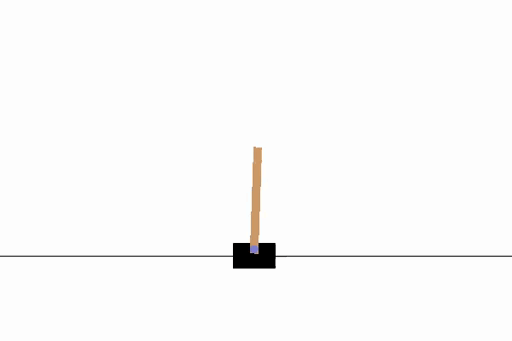
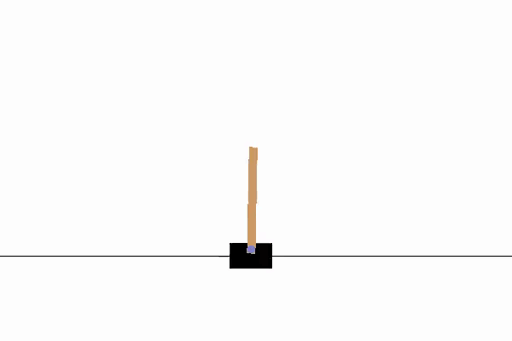
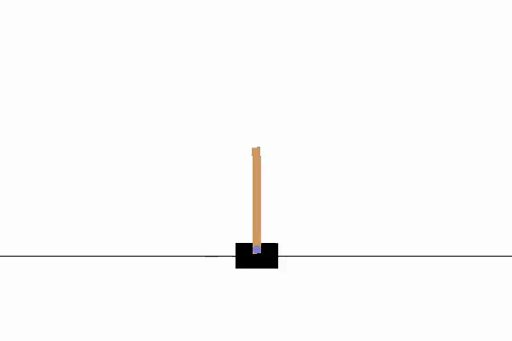

In [9]:
data = gt.get_gif_html_oai(env_videos=env.videos, 
                           title='PPO-CartPole',
                           max_n_videos=3)
HTML(data=data)

In [2]:
num_policies, n_vs_n=1, 1
register_env('gfootball_1v1', lambda _: ft.RllibGFootball(n_vs_n))
try:
    del env
except:
    pass
env = ft.RllibGFootball(n_vs_n=n_vs_n, auto_GK=True)
obs_space = env.observation_space
act_space = env.action_space

def gen_policy(_):
    return (None, obs_space, act_space, {})

policies = {
    'policy_{}'.format(i): gen_policy(i) for i in range(num_policies)
}
policy_ids = list(policies.keys())

In [3]:
env.action_space

Discrete(19)

In [4]:
env.observation_space

Box(-inf, inf, (115,), float32)

In [5]:
policies

{'policy_0': (None, Box(-inf, inf, (115,), float32), Discrete(19), {})}

In [6]:
policy_ids

['policy_0']

In [7]:
!rm -rf /tmp/logs/*

In [8]:
a = tune.run(
    "PPO",
    stop={
        "episode_reward_mean": 2,
        "timesteps_total": 5_000_000,
    },
    local_dir="/tmp/logs",
    name="football",
    num_samples=1,
    config={
        # "framework": "tfe",
        "env": "gfootball_1v1",

        "gamma": 0.99,
        "lr": 0.00005,

        "num_workers": 30,
        "num_gpus": 1,

        "log_level": "ERROR",
    },
    checkpoint_freq=10,
    checkpoint_at_end=True,
    verbose=1,
    keep_checkpoints_num=3,
    checkpoint_score_attr="episode_reward_mean",
)

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_gfootball_1v1_99335_00000,TERMINATED,,1,29.7205,6000,nan,nan,nan,nan


In [9]:
checkpoint_path = a.get_best_checkpoint(a.get_best_trial("episode_reward_mean", "max"), "episode_reward_mean", "max")
checkpoint_path

'/tmp/logs/football/PPO_gfootball_1v1_99335_00000_0_2020-11-07_00-38-47/checkpoint_1/checkpoint-1'

In [10]:
config = ppo.DEFAULT_CONFIG.copy()
config['num_workers'] = 0

agent = ppo.PPOTrainer(config, env='gfootball_1v1')
agent.restore(checkpoint_path)
policy = agent.workers.local_worker().get_policy()
get_action_for = lambda state: policy.compute_actions([state])[0][0]

2020-11-07 00:39:27,516	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2020-11-07 00:39:27,517	INFO trainer.py:618 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-11-07 00:39:34,351	INFO trainable.py:482 -- Restored on 172.17.0.2 from checkpoint: /tmp/logs/football/PPO_gfootball_1v1_99335_00000_0_2020-11-07_00-38-47/checkpoint_1/checkpoint-1
2020-11-07 00:39:34,353	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 29.72053575515747, '_episodes_total': 0}


In [11]:
env = ft.RllibGFootball(n_vs_n=n_vs_n, auto_GK=True)

In [12]:
env.reset()

{'agent_0': array([-1.0110294 , -0.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ,  0.        , -0.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        ,  1.0110294 ,
         0.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -0.        ,  0.   

In [14]:
!rm -rf /tmp/football/*
mdir = tempfile.mkdtemp()
env = ft.RllibGFootball(n_vs_n=n_vs_n, auto_GK=True)

for e in range(1,11):
    ret, done, obs = 0, False, env.reset()['agent_0']
    while not done:
        a = get_action_for(obs)
        obs, rew, done, info = env.step({'agent_0': a})
        obs, rew, done, info = obs['agent_0'], rew['agent_0'], done['__all__'], info['agent_0']
        ret += rew
    print("Episode={}, return={}".format(e, ret))

Episode=1, return=-2.0
Episode=2, return=-1.0
Episode=3, return=-3.0
Episode=4, return=-1.0
Episode=5, return=-1.0
Episode=6, return=0.0
Episode=7, return=-1.0
Episode=8, return=-1.0
Episode=9, return=-3.0
Episode=10, return=0.0



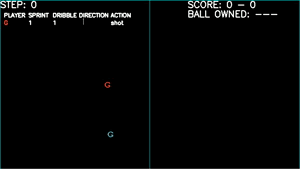
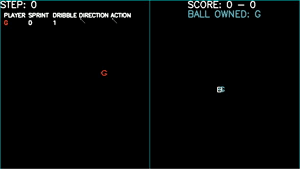
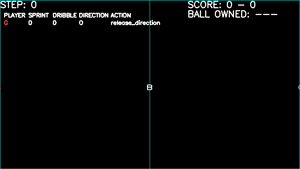

In [17]:
data = gt.get_gif_html(videos_path="/tmp/football/*.avi", 
                    title="GFootball Test",
                    max_n_videos=3)
HTML(data=data)

In [38]:
tune.run(
    'PPO',
    stop={'training_iteration': num_iters},
    checkpoint_freq=50,
    config={
        'env': 'gfootball',
        'lambda': 0.95,
        'kl_coeff': 0.2,
        'clip_rewards': False,
        'vf_clip_param': 10.0,
        'entropy_coeff': 0.01,
        'train_batch_size': 2000,
        'rollout_fragment_length': 100,
        'sgd_minibatch_size': 500,
        'num_sgd_iter': 10,
        'num_workers': 10,
        'num_envs_per_worker': 1,
        'batch_mode': 'truncate_episodes',
        'observation_filter': 'NoFilter',
        'vf_share_layers': True,
        'num_gpus': 1,
        'lr': 2.5e-4,
        'simple_optimizer': False,
        'multiagent': {
            'policies': policies,
            'policy_mapping_fn': tune.function(
                lambda agent_id: policy_ids[int(agent_id[6:])]),
        },
        'log_level': 'INFO',
    },
    verbose=1,
)

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_gfootball_be6f2_00000,RUNNING,172.17.0.2:4623,15,2016.23,30000,1.5,2,0,24.43


KeyboardInterrupt: 

In [ ]:
tune.run(
    'PPO',
    stop={'training_iteration': num_iters},
    checkpoint_freq=50,
    config={
        'env': 'gfootball2',
        'lambda': 0.95,
        'kl_coeff': 0.2,
        'clip_rewards': False,
        'vf_clip_param': 10.0,
        'entropy_coeff': 0.01,
        'train_batch_size': 2000,
        'rollout_fragment_length': 100,
        'sgd_minibatch_size': 500,
        'num_sgd_iter': 10,
        'num_workers': 10,
        'num_envs_per_worker': 1,
        'batch_mode': 'truncate_episodes',
        'observation_filter': 'NoFilter',
        'vf_share_layers': True,
        'num_gpus': 1,
        'lr': 2.5e-4,
        'simple_optimizer': False,
        'multiagent': {
            'policies': policies,
            'policy_mapping_fn': tune.function(
                lambda agent_id: policy_ids[int(agent_id[6:])]),
        },
        'log_level': 'INFO',
    },
    verbose=1,
)

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_gfootball2_01f3a_00000,RUNNING,172.17.0.2:4699,2703,24468.9,5406000,-0.42,0,-6,1001
